In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install requests beautifulsoup4 nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
from bs4 import BeautifulSoup
import os
import time
from urllib.parse import urlparse
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler('crawler.log'), logging.StreamHandler()]
)

# Define categories and their associated websites
categories = {
    "technology_news": ["https://techcrunch.com", "https://theverge.com", "https://wired.com"],
    "science": ["https://scientificamerican.com", "https://nature.com", "https://sciencedaily.com"],
    "health_wellness": ["https://webmd.com", "https://mayoclinic.org", "https://healthline.com"],
    "finance": ["https://bloomberg.com", "https://ft.com", "https://cnbc.com"],
    "travel": ["https://lonelyplanet.com", "https://tripadvisor.com", "https://nationalgeographic.com/travel"],
    "food_cooking": ["https://epicurious.com", "https://foodnetwork.com", "https://bonappetit.com"],
    "sports": ["https://espn.com", "https://si.com", "https://bleacherreport.com"],
    "entertainment": ["https://variety.com", "https://hollywoodreporter.com", "https://ew.com"],
    "education": ["https://khanacademy.org", "https://coursera.org", "https://edx.org"],
    "environment": ["https://nationalgeographic.com/environment", "https://greenpeace.org", "https://edf.org"],
    "fashion": ["https://vogue.com", "https://gq.com", "https://elle.com"],
    "automotive": ["https://caranddriver.com", "https://motortrend.com", "https://autoweek.com"],
    "gaming": ["https://polygon.com", "https://ign.com", "https://kotaku.com"],
    "diy_crafts": ["https://instructables.com", "https://hgtv.com", "https://diynetwork.com"],
    "parenting": ["https://parents.com", "https://babycenter.com", "https://whattoexpect.com"],
    "real_estate": ["https://zillow.com", "https://realtor.com", "https://redfin.com"],
    "fitness": ["https://menshealth.com", "https://womenshealth.com", "https://shape.com"],
    "pets": ["https://thesprucepets.com", "https://petmd.com", "https://akc.org"],
    "career_jobs": ["https://linkedin.com/pulse", "https://indeed.com/career-advice", "https://glassdoor.com/blog"],
    "history": ["https://history.com", "https://smithsonianmag.com", "https://ancient.eu"]
}

# Create a directory to store raw data
if not os.path.exists('raw_data'):
    os.makedirs('raw_data')

# Create headers to mimic a browser
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
}

def extract_domain(url):
    """Extract domain name from URL."""
    parsed_uri = urlparse(url)
    domain = '{uri.netloc}'.format(uri=parsed_uri)
    return domain.replace('www.', '')

def get_article_links(url, max_links=5):
    """Get links to articles from the given URL."""
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Look for common article link patterns
        links = []
        
        # Find links with common article patterns
        article_candidates = []
        
        # Look for <a> tags with 'article' in href
        for a in soup.find_all('a', href=True):
            href = a['href']
            if 'article' in href or 'post' in href or 'story' in href or 'news' in href or '/20' in href:
                article_candidates.append(href)
        
        # If not enough candidates, try links in common article containers
        if len(article_candidates) < max_links:
            for container in soup.select('article, .article, .post, .story, .news-item, .entry'):
                for a in container.find_all('a', href=True):
                    article_candidates.append(a['href'])
        
        # Process the links to ensure they are absolute URLs
        domain = extract_domain(url)
        base_url = f"https://{domain}"
        
        for link in article_candidates:
            # Make relative URLs absolute
            if link.startswith('/'):
                link = base_url + link
            elif not link.startswith('http'):
                link = base_url + '/' + link
            
            # Skip non-article links like homepage, category pages, etc.
            if domain in link and link not in links:
                links.append(link)
                if len(links) >= max_links:
                    break
        
        return links[:max_links]
        
    except Exception as e:
        logging.error(f"Error fetching article links from {url}: {e}")
        return []

def extract_article_content(url):
    """Extract title, content and publication date from the article."""
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Extract title
        title = ""
        title_tag = soup.find('h1') or soup.find('title')
        if title_tag:
            title = title_tag.get_text().strip()
        
        # Extract publication date
        date = ""
        date_candidates = soup.find_all(['time', 'span', 'p', 'div'], class_=lambda c: c and ('date' in c.lower() or 'time' in c.lower() or 'published' in c.lower()))
        if date_candidates:
            date = date_candidates[0].get_text().strip()
        
        # Extract content
        content = ""
        
        # Try common article content containers
        content_selectors = [
            'article', '.article-content', '.post-content', '.entry-content', 
            '.story-content', '.content-body', '.story-body', 'main', '#content',
            '[itemprop="articleBody"]', '.article__content', '.article-body'
        ]
        
        for selector in content_selectors:
            content_container = soup.select_one(selector)
            if content_container:
                # Get paragraphs
                paragraphs = content_container.find_all('p')
                if paragraphs:
                    content = '\n'.join([p.get_text().strip() for p in paragraphs])
                    break
        
        # If no content found with selectors, try getting all paragraphs from the body
        if not content:
            paragraphs = soup.find_all('p')
            content = '\n'.join([p.get_text().strip() for p in paragraphs])
        
        return {
            'title': title,
            'date': date,
            'content': content,
            'url': url
        }
        
    except Exception as e:
        logging.error(f"Error extracting content from {url}: {e}")
        return {'title': '', 'date': '', 'content': '', 'url': url}

def crawl_website(category, website_url):
    """Crawl the website and extract content from articles."""
    logging.info(f"Crawling {website_url} for category {category}")
    
    # Get article links
    article_links = get_article_links(website_url)
    
    articles_data = []
    for link in article_links:
        logging.info(f"Extracting content from {link}")
        article_data = extract_article_content(link)
        
        if article_data['content']:
            articles_data.append(article_data)
            
        # Be respectful to the website by adding a delay
        time.sleep(2)
    
    return articles_data

def save_to_file(category, data):
    """Save the extracted data to a file."""
    filename = os.path.join('raw_data', f"{category}.txt")
    
    with open(filename, 'w', encoding='utf-8') as f:
        for article in data:
            f.write(f"TITLE: {article['title']}\n")
            f.write(f"DATE: {article['date']}\n")
            f.write(f"URL: {article['url']}\n")
            f.write(f"CONTENT:\n{article['content']}\n")
            f.write("-" * 80 + "\n\n")
    
    logging.info(f"Saved data for category {category} to {filename}")

def main():
    """Main function to crawl websites for all categories."""
    for category, websites in categories.items():
        logging.info(f"Processing category: {category}")
        
        all_articles = []
        for website in websites:
            articles = crawl_website(category, website)
            all_articles.extend(articles)
            
            # Be respectful to the next website by adding a delay
            time.sleep(5)
        
        save_to_file(category, all_articles)

if __name__ == "__main__":
    main()

## All the logs are stored in crawler.log

In [7]:
import os
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler('preprocessing.log'), logging.StreamHandler()]
)

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Create a directory to store cleaned data
if not os.path.exists('cleaned_data'):
    os.makedirs('cleaned_data')

def remove_html_tags(text):
    """Remove HTML tags from the text."""
    return BeautifulSoup(text, "html.parser").get_text()

def remove_urls(text):
    """Remove URLs from the text."""
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)

def remove_punctuation(text):
    """Remove punctuation from the text."""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def remove_numbers(text):
    """Remove numbers from the text."""
    return re.sub(r'\d+', '', text)

def remove_stopwords(text, lang='english'):
    """Remove stop words from the text."""
    stop_words = set(stopwords.words(lang))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

def normalize_whitespace(text):
    """Normalize whitespace in the text."""
    return re.sub(r'\s+', ' ', text).strip()

def clean_text(text):
    """Apply all cleaning steps to the text."""
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = text.lower()
    text = remove_stopwords(text)
    text = normalize_whitespace(text)
    return text

def process_category_file(category):
    """Process a category file and clean its text."""
    input_file = os.path.join('raw_data', f"{category}.txt")
    output_file = os.path.join('cleaned_data', f"{category}_cleaned.txt")
    
    if not os.path.exists(input_file):
        print(f"Input file not found: {input_file}")
        return
    
    print(f"Processing category: {category}")
    
    try:
        with open(input_file, 'r', encoding='utf-8') as f:
            text = f.read()
        
        # Split the file into articles
        articles = text.split("-" * 80)
        
        cleaned_articles = []
        
        for article in articles:
            if not article.strip():
                continue
                
            # Extract content section
            content_match = re.search(r'CONTENT:\n(.*?)(?=\n\n|$)', article, re.DOTALL)
            
            if content_match:
                content = content_match.group(1)
                cleaned_content = clean_text(content)
                
                # Extract title for reference
                title_match = re.search(r'TITLE: (.*?)\n', article)
                title = title_match.group(1) if title_match else "No Title"
                
                cleaned_articles.append(f"TITLE: {title}\nCLEANED CONTENT:\n{cleaned_content}\n")
        
        # Write cleaned articles to output file
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write("\n".join(cleaned_articles))
            
        print(f"Cleaned data saved to {output_file}")
        
    except Exception as e:
        print(f"Error processing {category}: {e}")

def main():
    """Main function to process all category files."""
    # Get all categories from raw_data directory
    categories = [f.split('.')[0] for f in os.listdir('raw_data') if f.endswith('.txt')]
    
    for category in categories:
        process_category_file(category)
        
    logging.info("Text preprocessing completed for all categories")

main()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Processing category: fashion
Cleaned data saved to cleaned_data/fashion_cleaned.txt
Processing category: sports
Cleaned data saved to cleaned_data/sports_cleaned.txt
Processing category: pets
Cleaned data saved to cleaned_data/pets_cleaned.txt
Processing category: fitness
Cleaned data saved to cleaned_data/fitness_cleaned.txt
Processing category: gaming
Cleaned data saved to cleaned_data/gaming_cleaned.txt
Processing category: science
Cleaned data saved to cleaned_data/science_cleaned.txt
Processing category: diy_crafts
Cleaned data saved to cleaned_data/diy_crafts_cleaned.txt
Processing category: career_jobs
Cleaned data saved to cleaned_data/career_jobs_cleaned.txt
Processing category: history
Cleaned data saved to cleaned_data/history_cleaned.txt


In [8]:
import shutil

# Move dataset to the working directory
shutil.make_archive("/kaggle/working/cleaned_data", 'zip', "cleaned_data")

'/kaggle/working/cleaned_data.zip'

In [9]:
import shutil

# Move dataset to the working directory
shutil.make_archive("/kaggle/working/raw_data", 'zip', "raw_data")

'/kaggle/working/raw_data.zip'

## The data is from different sectors , so I would like to use some pretrained models to learn embeddings for my data and do clustering and see which sectors fall close to each others.

In [2]:
import os  

folder_path = "/kaggle/input/text-data/Task-B/crawler (1)"
sector_texts = {}  

# Read each file and store its content
for file_name in os.listdir(folder_path):
    if file_name.endswith(".txt"):
        sector_name = file_name.replace("_cleaned.txt", "")  
        with open(os.path.join(folder_path, file_name), "r", encoding="utf-8") as f:
            sector_texts[sector_name] = f.read()


In [5]:
from sentence_transformers import SentenceTransformer  

# Load the model
model = SentenceTransformer('all-MiniLM-L6-v2')  

# Compute embeddings
sector_embeddings = {sector: model.encode(text, convert_to_tensor=True) for sector, text in sector_texts.items()}


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
import numpy as np  
from sklearn.cluster import KMeans  

# Convert embeddings to a NumPy array
embedding_matrix = np.array([emb.cpu().numpy() for emb in sector_embeddings.values()])  

# Apply K-Means clustering
num_clusters = 5  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)  
labels = kmeans.fit_predict(embedding_matrix)  

# Map clusters to sector names
sector_clusters = {sector: label for sector, label in zip(sector_embeddings.keys(), labels)}
print(sector_clusters)  # Shows which sectors are in the same cluster


{'history': 1, 'education': 4, 'finance': 4, 'health_wellness': 3, 'automotive': 4, 'pets': 4, 'real_estate': 2, 'science': 4, 'gaming': 4, 'entertainment': 4, 'fitness': 4, 'parenting': 4, 'sports': 2, 'environment': 2, 'diy_crafts': 0, 'travel': 1, 'career_jobs': 0, 'technology_news': 4, 'food_cooking': 3, 'fashion': 1}


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
# !pip install adjustText

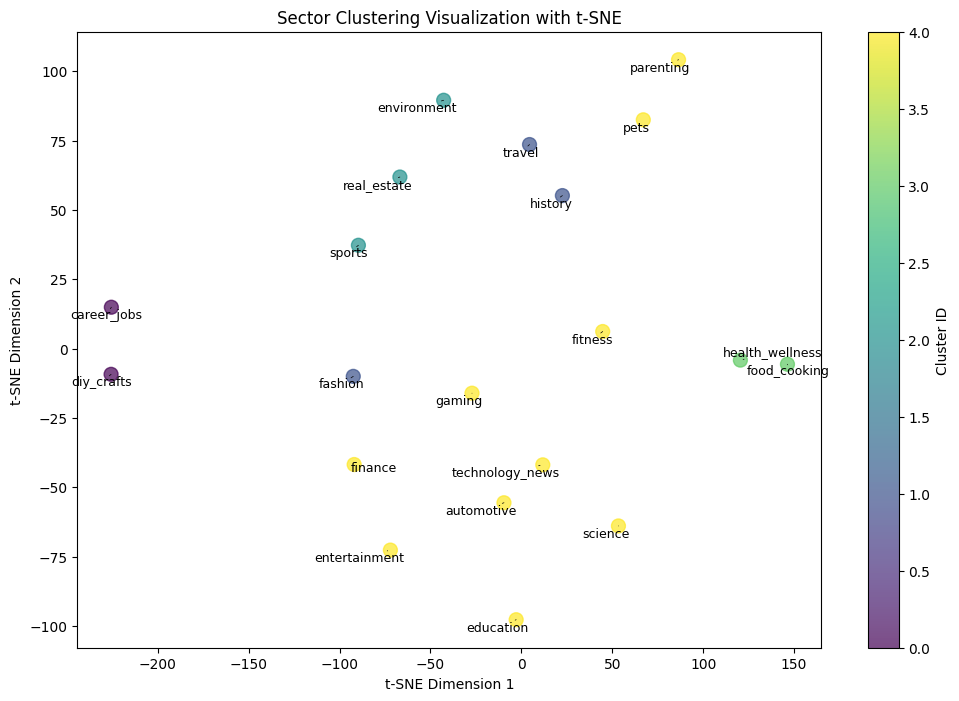

In [10]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text  # Automatically adjusts text labels

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
reduced_embeddings = tsne.fit_transform(embedding_matrix)

# Plot clusters
plt.figure(figsize=(12, 8))  # Increase figure size
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap="viridis", s=100, alpha=0.7)

# Add text labels for sectors
texts = []
for (x, y), sector in zip(reduced_embeddings, sector_embeddings.keys()):
    texts.append(plt.text(x, y, sector, fontsize=9, ha="center", va="center"))

# Adjust text positions to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# Titles and labels
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("Sector Clustering Visualization with t-SNE")
plt.colorbar(scatter, label="Cluster ID")  # Add a color legend for clusters
plt.show()
